# Dam: You're Really Disrupting the Flow
Emi Fergus, Brian Pinke, and Korrina Rantz  
In partnership with Jeff Opperman and Natalie Sharbol WWF
06//2021

![dam-image](https://southeastaquatics.net/news/BeforeandAfterWhiteDamRemoval.jpg)

Picture showing the before and after of the White Dam Removal by the Georgia Water Coalition

## Introduction

Only one-third of the world’s large rivers still have their free-flowing status, meaning river segments are connected from a river’s headwater to the final downstream outlet. Dams are the main cause of river fragmentation and loss in connectivity. However, not all dams are built the same, nor serve the same purpose, and thus may have different effects on river connectivity. Dams are constructed for drinking water reservoirs, water for irrigation, flood control, hydroelectricity, and recreation, to name a few.  We have used dams to control rivers for our needs and this fragmentation has had a negative impact on biodiversity and the overall health of riparian systems. The disruption in movement and exchange of water, nutrients, organisms and sediment has impacted ecosystem processes. 

For this project, we performed global analyses examining relationships between dam types and river connectivity characteristics. In particular, we examined how these relationships varied across six continents. These findings will support conservation efforts by identifying which dam types have greater impacts on river connectivity. This information can be used to create sound arguments against the construction of new dams and help with proposals to remove and manage existing dams.

![FreeFlowingRiversCSI](https://ndownloader.figshare.com/files/27829941)
Figure 1: Free Flowing Rivers of the World with Connectivity Status Index (Grill et al., 2019).

![GrandImage](https://ndownloader.figshare.com/files/27829938)
Figure 2: Global distribution (by country) of large reservoirs and dams in GRanD database (GRanD Technical Documentation V1.3).

## Findings

From continent to continent, we see differences in the abundances of dams that are built to serve different purposes. Hydroelectric dams are one of the most prevalent dam types, especially in developed continents of Europe and North America. In contrast, the most prevalent dams in Africa and Asia are built for irrigation purposes. 
We found associations among dam type and the amount of river flow (or discharge) that the dams intercept along a river network. Hydroelectric dams intercept some of the greatest volumes of river flow compared to other dam types, and this relationship is consistent across the six continents.

These findings indicate that hydroelectric dams make up the greatest number of dams constructed globally and may be a driving force for constructing dams in new locations. We also see that hydroelectric dams may have some of the greatest impacts on river connectivity in that they are commonly built on river reaches moving large volumes of water. These dams may disrupt the flow of water, materials, sediment, and organisms from reaching the final river outlet whether it be the ocean or an inland waterbody. 


## Methods

In order to do this analysis, we used two pre-existing databases: 1. The Free-Flowing Rivers (FFR), which is a global river dataset with information on how fragmented the river flow is, and 2. the Global Reservoirs and Dams database, which is a global dam dataset with information on types of dams and their locations. Using these two datasets we are able to tease out information on the relations between dam type and river flow disruption. 

Our main efforts towards understanding the underlying relationships have been two-fold. First we determine the number of each dam type present on each continent. This gives us a sense as to what types of dams might be impacting the rivers on continent scales. This analysis is displayed by bar plots. Second, we determine the amount of cumulative river flow intercepted by each dam type, also subset by each continent. Generally, the larger the amount of river flow intercepted by a dam type, the higher the disruption that dam type is causing. This analysis is displayed by box and whisker plots.

If you are curious to see the technical processing and code behind the analysis, please check out our <a href="https://github.com/krantz23/ffr-dam-impact" target="_blank"> GitHub Repository </a> .

In [1]:
# Import packages 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import fiona
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import rasterio as rio
import requests
import seaborn as sns
import zipfile
import earthpy as et
import urllib.request
import warnings
import sys
#sys.setrecursionlimit(10000)

# Ignore runtime warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

In [2]:
# List functions needed to run code
# Create code to make bar charts
def dam_type_plot(dam_continent, continent_name, plt_ax):
    """Take the continent df, continent name, and indicated subplot axis, and create a subplot barplot.

    Parameters
    -----------
    dam_continent : dataFrame
        GRanD dataframe subset by continent.
    continent_name : string
        String of continent name.
    plt_ax : variable
        Variable name indicating which matplotlib axis to plot on.

    Returns
    -----------
    plt_ax : matplotlib axis
        Matplotlib axis for plotting on a subplot.
    """

    # Loop through df, grouped by main use and create subplot
    for ctype, dam in dam_continent.groupby("MAIN_RED"):
        color_dam = dam_color[ctype]
        label = ctype
        dam_count = dam.count()
        plt_ax.bar(ctype,
                dam_count["GRAND_ID"],
                color=color_dam,
                label=label)
        plt_ax.set(ylabel="Count")
        plt_ax.set_ylim(0, 700)
        plt_ax.set_title(continent_name, fontsize=30)
    plt_ax.grid(axis="y")

    return plt_ax

def dam_box_plot(dam_continent, continent_name, plt_ax):
    """Take the continent df, continent name, and indicated subplot axis, and create a subplot boxplot.

    Parameters
    -----------
    dam_continent : dataFrame
        GRanD dataframe subset by continent.
    continent_name : string
        String of continent name.
    plt_ax : variable
        Variable name indicating which matplotlib axis to plot on.

    Returns
    -----------
    plt_ax : matplotlib axis
        Matplotlib axis for plotting on a subplot.
    """

    # Loop through df, grouped by main use and create subplot
    sns.boxplot(x="MAIN_RED", y="ln_DIS_AVG_LS",
                data=dam_continent, palette=dam_color, ax=plt_ax)
    plt_ax.xaxis.set_tick_params(rotation=45)
    plt_ax.set(xlabel="", ylabel="Average Discharge in liters/sec (ln)")
    plt_ax.set_title(continent_name, fontsize=30)

    return plt_ax

In [3]:
# Download data and read in
# Country boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/22507058")
countries_path = os.path.join("earthpy-downloads", "country-borders",
                              "99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp")
countries_border = gpd.read_file(countries_path)

# Get merged GRanD-FFR dataset
grand_ffr_path = ("GRAND_FFR.csv")
grand_ffr_df = pd.read_csv(grand_ffr_path)
# Create a new dataframe with only needed columns
grand_ffr = grand_ffr_df[['GRAND_ID','DAM_NAME', 'DIS_AVG_LS', 'MAIN_USE', 'LONG_DD', 'LAT_DD', 'MAIN_RED', 
                          'MAIN_HYDEXP', 'MAIN_HYDRO', 'HYDELEC_code', 'CONTINENT', 'COUNTRY',
                          'DIS_AV_CMS', 'RIV_ORD', 'CSI']]
# Convert pandas dataframe into a geodataframe
geometry = [Point(xy) for xy in zip(grand_ffr.LONG_DD, grand_ffr.LAT_DD)]
grand_ffr = grand_ffr.drop(['LONG_DD', 'LAT_DD'], axis=1)
grand_ffr_gdf = GeoDataFrame(grand_ffr, crs="EPSG:4326", geometry=geometry)
grand_ffr_gdf

,GRAND_ID,DAM_NAME,DIS_AVG_LS,MAIN_USE,MAIN_RED,MAIN_HYDEXP,MAIN_HYDRO,HYDELEC_code,CONTINENT,COUNTRY,DIS_AV_CMS,RIV_ORD,CSI,geometry
0,2555,Diama,139110,Irrigation,Irrigation,Irrigation,Irrigation,0,Africa,Mauritania,135.628,4,19.95024,POINT (-16.41346 16.21864)
1,2928,Sghir,521,Irrigation,Irrigation,Irrigation,Irrigation,0,Africa,Morocco,0.687,7,52.52858,POINT (-5.38629 35.68414)
2,2929,Ibn Batouta,1678,Water supply,Water supply,Water supply,Water supply,0,Africa,Morocco,1.740,6,31.61437,POINT (-5.73055 35.63968)
3,2930,Ajras,346,Irrigation,Irrigation,Irrigation,Irrigation,0,Africa,Morocco,0.349,7,47.76043,POINT (-5.49271 35.56808)
4,2931,Nakhla,1033,Water supply,Water supply,Water supply,Water supply,0,Africa,Morocco,1.074,6,44.62490,POINT (-5.40708 35.44654)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7298,7053,Arenoso,937,Irrigation,Irrigation,Hydro_irrig,Hydroelectricity,1,Europe,Spain,0.028,8,100.00000,POINT (-4.44030 38.02203)
7299,7056,Los Melonares,7586,Water supply,Water supply,Water supply,Water supply,0,Europe,Spain,0.061,8,98.95545,POINT (-5.88171 37.72357)
7300,7058,Mularroya,84,Irrigation,Irrigation,Irrigation,Irrigation,0,Europe,Spain,469.690,4,57.76359,POINT (-1.42801 41.46793)
7301,7059,San Salvador,163,Irrigation,Irrigation,Irrigation,Irrigation,0,Europe,Spain,0.101,7,99.80495,POINT (0.18156 41.77348)


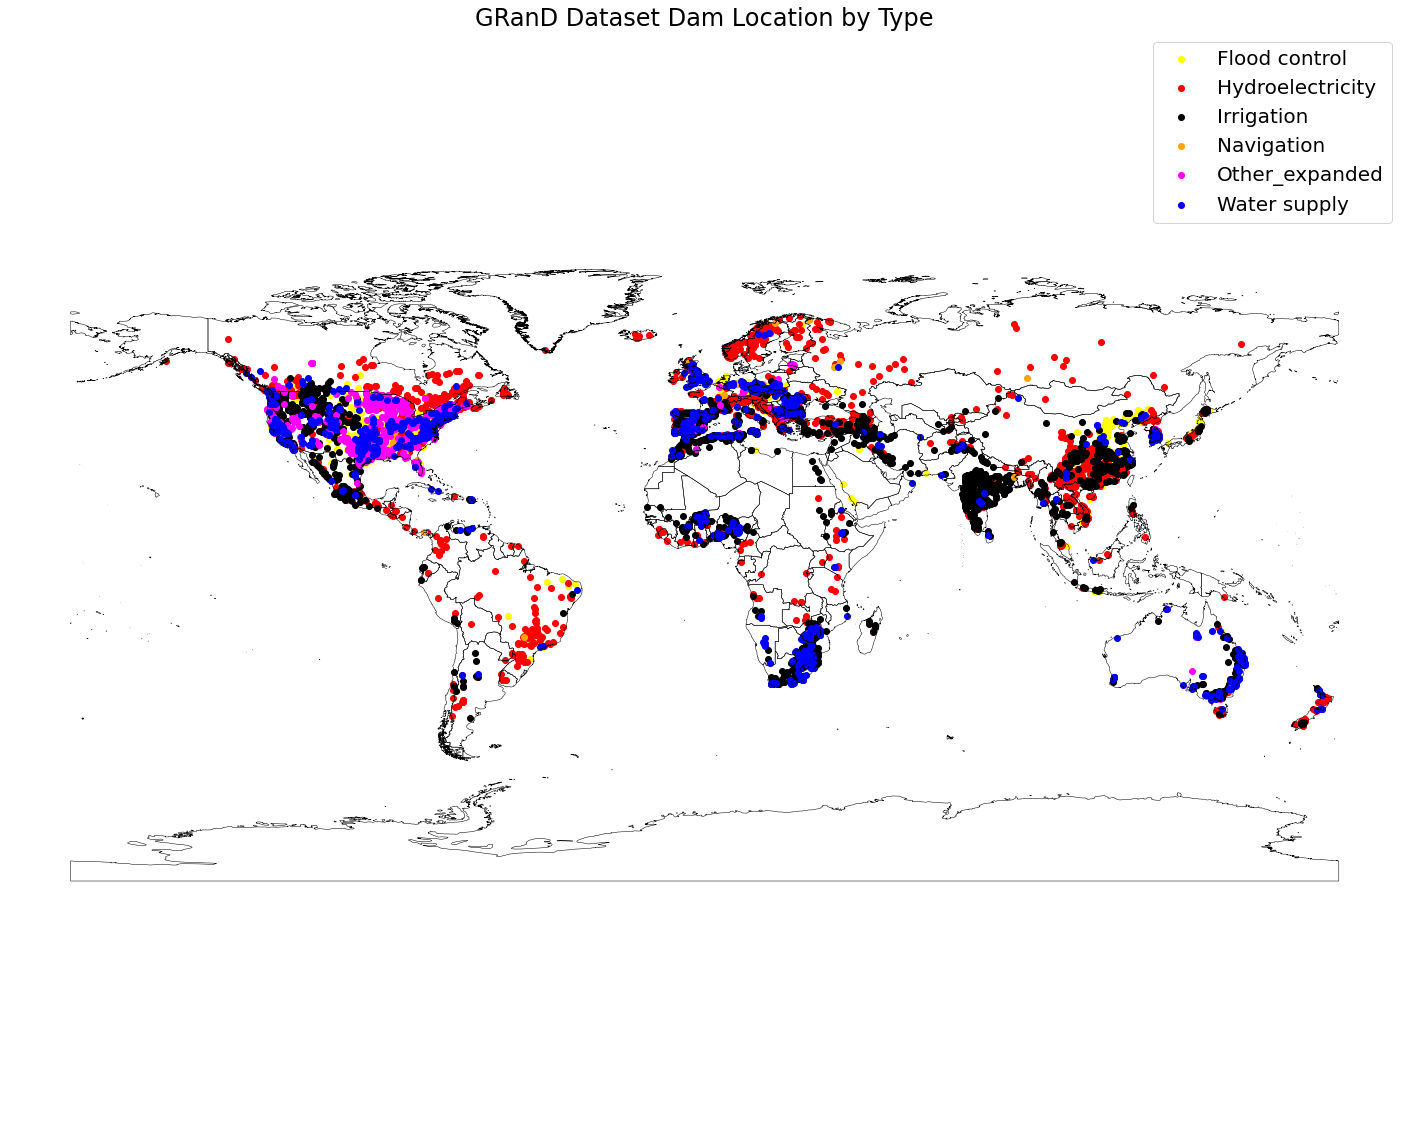

In [4]:
# Create global map figure of dam types
# Color dictionary
dam_color = {'Irrigation': 'black',
             'Hydroelectricity': 'red',
             'Water supply': 'blue',
             'Flood control': 'yellow',
             'Navigation': 'orange',
             'Other_expanded': 'magenta'}

# Plot the data
fig, ax = plt.subplots(figsize=(25, 20))

# Plot each dam colored by Main Use
for ctype, dams in grand_ffr_gdf.groupby('MAIN_RED'):
    color_dam = dam_color[ctype]
    label = ctype
    dams.plot(color=color_dam,
              ax=ax,
              label=label)

# Plot the global countries borders map
countries_border.plot(color="none", edgecolor="black", linewidth=.5, ax=ax)

# Set legend, title, and plot settings
ax.legend()
ax.set_title("GRanD Dataset Dam Location by Type", fontsize=24)
plt.legend(fontsize=20)
ax.set_axis_off()
plt.axis('equal')

plt.show()

Study area map of the globe showing the distribution of dams, color coded by main use of dam.

In [5]:
## TODO eliminate country lists by using .isin("continent"==x)
# Create list of countries in each continent
africa_country = ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Cameroon',
                  'Congo', 'Congo (DRC)', 'Egypt', 'Eritrea', 'Ethiopia', 'Gabon',
                  'Ghana', 'Guinea', 'Ivory Coast', 'Kenya', 'Lesotho', 'Liberia',
                  'Libya', 'Madagascar', 'Mali', 'Mauritania', 'Morocco', 'Mozambique',
                  'Namibia', 'Nigeria', 'Senegal', 'Sierra Leone', 'South Africa',
                  'Sudan', 'Swaziland', 'Tanzania', 'Togo', 'Tunisia', 'Uganda',
                  'Zambia', 'Zimbabwe']

asia_country = ['Afghanistan', 'Bahrain', "Bangladesh", "Bhutan", "Brunei",
                'Myanmar (Burma)', 'Myanmar', 'Cambodia', 'China', 'East Timor',
                'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan',
                'Kazakhstan', 'North Korea', 'South Korea', 'Kuwait', 'Kyrgyzstan',
                'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Nepal',
                'Oman', 'Pakistan', 'Philippines', 'Qatar', 'Russia', 'Saudi Arabia',
                'Singapore', 'Sri Lanka', 'Syria', 'Tajikistan', 'Thailand',
                'Turkey', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan',
                'Vietnam', 'Yemen']

europe_country = ['Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus',
                  'Belgium', 'Bosnia', 'Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
                  'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
                  'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland',
                  'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg',
                  'Macedonia', 'Malta', 'Moldova', 'Monaco', 'Montenegro',
                  'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'San Marino',
                  'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
                  'Switzerland', 'Ukraine', 'United Kingdom', 'Vatican City']

namerica_country = ['Antigua', 'Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Canada',
                    'Costa Rica', 'Cuba', 'Dominica', 'Congo (DRC)', ' Dominican Republic',
                    'El Salvador', 'Grenada', 'Guatemala', 'Haiti', 'Honduras',
                    'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Saint Kitts',
                    'Nevis', 'Saint Lucia', 'Saint Vincent', 'Grenadines', 'Trinidad',
                    'Tobago', 'United States']

samerica_country = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador',
                    'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela']

oceania_country = ['Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia',
                   'Nauru', 'New Zealand', 'Palau', 'Papua New Guinea', 'Samoa',
                   'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu']
  
dam_africa = grand_ffr_gdf[grand_ffr_gdf['COUNTRY'].isin(africa_country)]
dam_asia = grand_ffr_gdf[grand_ffr_gdf['COUNTRY'].isin(asia_country)]
dam_europe = grand_ffr_gdf[grand_ffr_gdf['COUNTRY'].isin(europe_country)]
dam_namerica = grand_ffr_gdf[grand_ffr_gdf['COUNTRY'].isin(namerica_country)]
dam_samerica = grand_ffr_gdf[grand_ffr_gdf['COUNTRY'].isin(samerica_country)]
dam_oceania = grand_ffr_gdf[grand_ffr_gdf['COUNTRY'].isin(oceania_country)]

continent_dams_list = [dam_africa, dam_asia, dam_europe, dam_namerica, dam_samerica, dam_oceania]
continent_list = ["Africa", "Asia", "Europe", "North America", "South America", "Australia/Oceania"]

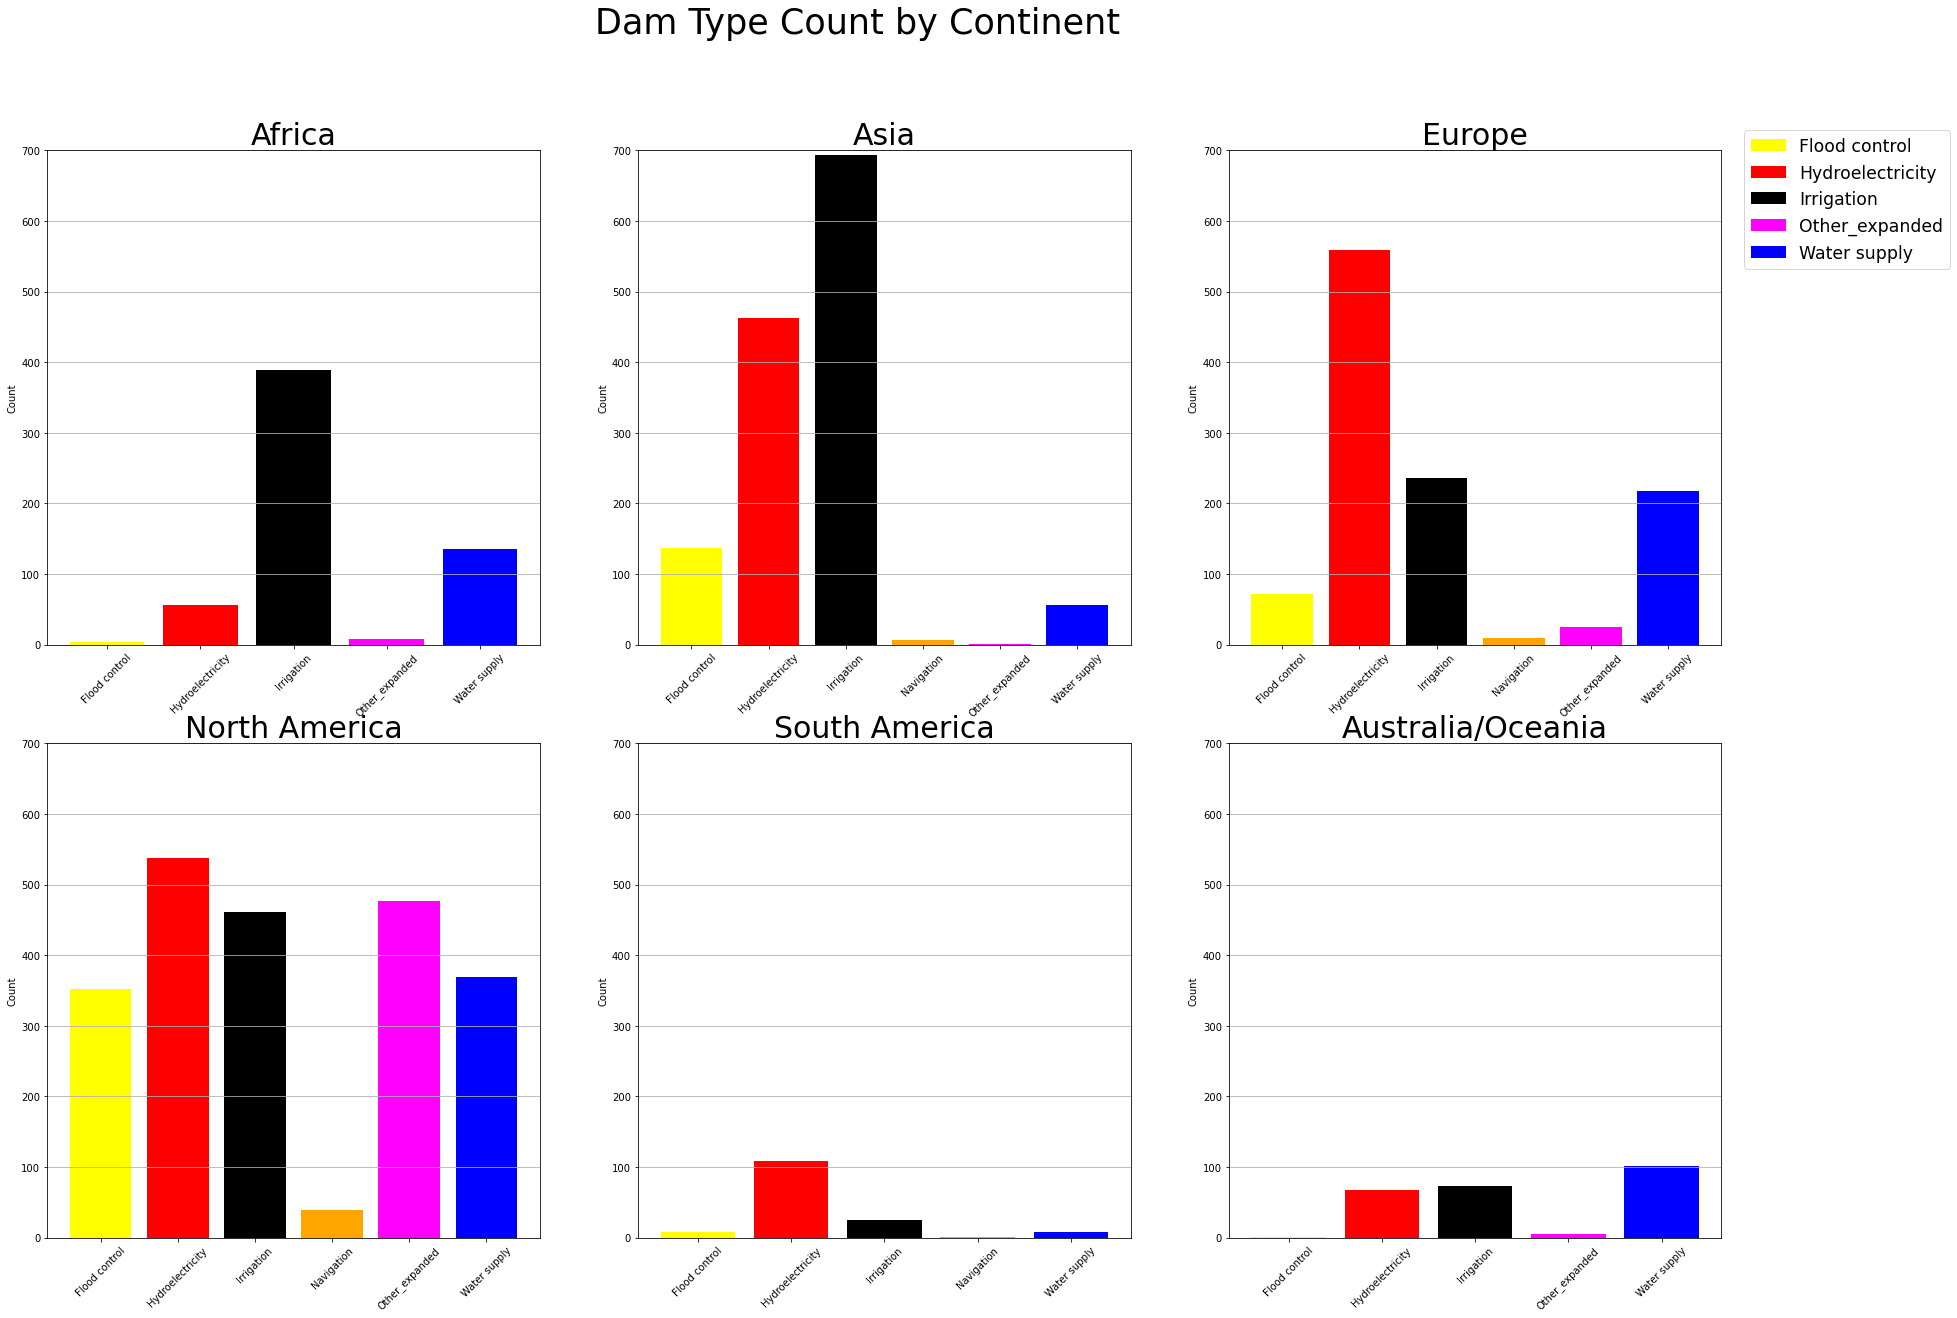

In [6]:
# Create barchart figure of dam type counts by continent using function

# Plot the data
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    ncols=3, nrows=2, figsize=(30, 20))
fig.suptitle("Dam Type Count by Continent", fontsize=35)

# Create Plots
# Plot Africa
dam_type_plot(continent_dams_list[0], continent_list[0], ax1)

# Plot Asia
dam_type_plot(continent_dams_list[1], continent_list[1], ax2)

# Plot Europe
dam_type_plot(continent_dams_list[2], continent_list[2], ax3)

# Plot North America
dam_type_plot(continent_dams_list[3], continent_list[3], ax4)

# Plot South America
dam_type_plot(continent_dams_list[4], continent_list[4], ax5)

# Plot Australia and Oceania
dam_type_plot(continent_dams_list[5], continent_list[5], ax6)


# Rotate x-axis labels
plt.setp((ax1.get_xticklabels(), ax2.get_xticklabels(), ax3.get_xticklabels(
), ax4.get_xticklabels(), ax5.get_xticklabels(), ax6.get_xticklabels(), ), rotation=45)

# Create legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc=1, bbox_to_anchor=(
    1.01, 0.9), fontsize='xx-large')

plt.show()

Barcharts showing the distribution of dam type across continents.

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


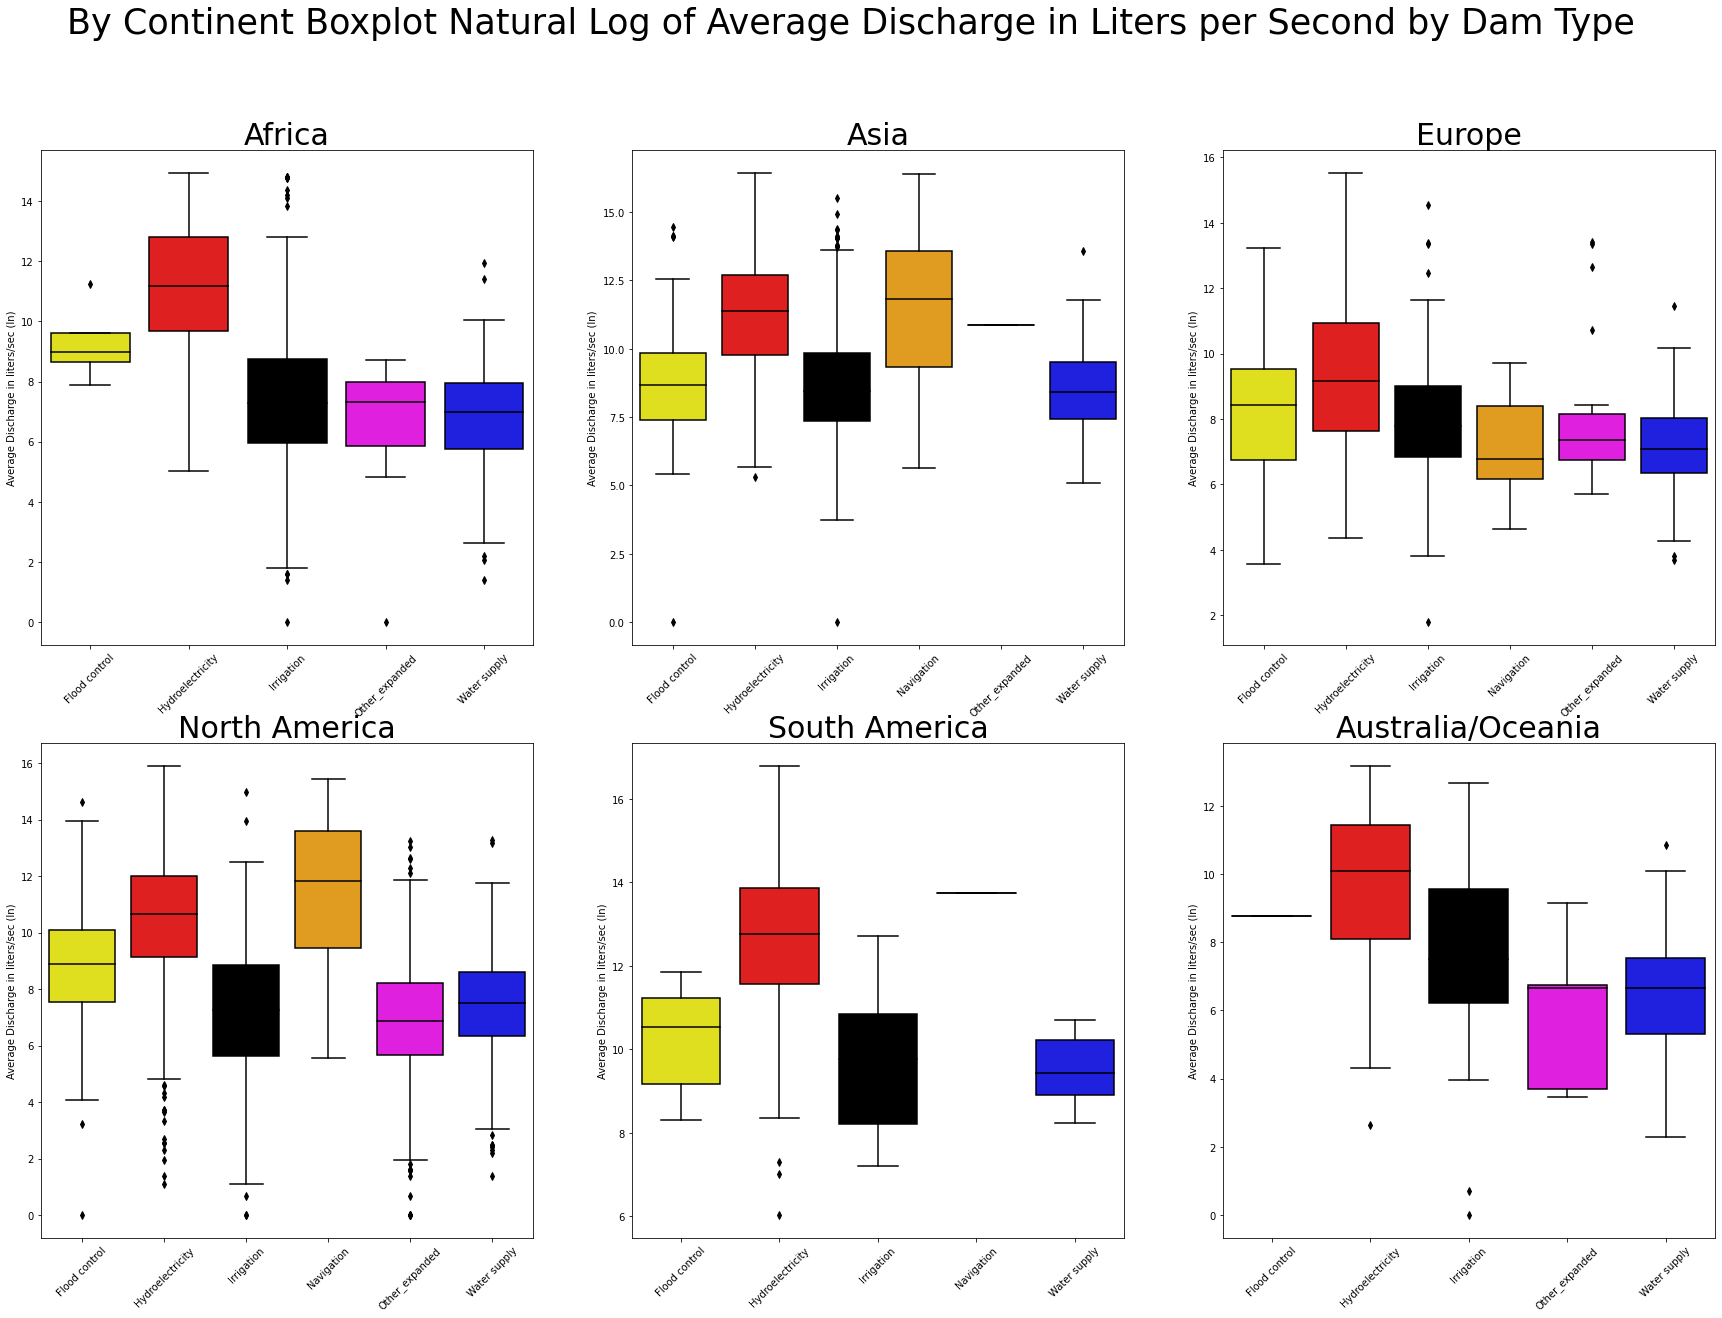

In [7]:
# BOXPLOTS Average Discharge (ln) BY DAM TYPE
# Loop processing to create log discharge values for boxplots
x =0
for continent in continent_dams_list:
  continent_dams_list[x]['ln_DIS_AVG_LS'] = np.log(continent_dams_list[x]['DIS_AVG_LS'])
  continent_dams_list[x] = continent_dams_list[x].sort_values('MAIN_RED')
  x += 1

# Create boxplot figure of dam type counts by continent

# Plot the data
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    ncols=3, nrows=2, figsize=(30, 20))
fig.suptitle(
    "By Continent Boxplot Natural Log of Average Discharge in Liters per Second by Dam Type", fontsize=35)

# Create plots
# Plot Africa
dam_box_plot(continent_dams_list[0], continent_list[0], ax1)

# Plot Asia
dam_box_plot(continent_dams_list[1], continent_list[1], ax2)

# Plot Europe
dam_box_plot(continent_dams_list[2], continent_list[2], ax3)

# Plot North America
dam_box_plot(continent_dams_list[3], continent_list[3], ax4)

# Plot South America
dam_box_plot(continent_dams_list[4], continent_list[4], ax5)

# Plot Australia and Oceania
dam_box_plot(continent_dams_list[5], continent_list[5], ax6)


plt.show()

Box plots showing the distribution of type of dam by average amount of discharge in liters per second

## Final Discussion

We can see geographic patterns in the types of dams and distribution by continent through our mapping and bar chart. As we continue to explore the data we want to spatially join this information with the FFR.  The FFR is very data rich and poses challenges to work with. Subsetting the data by region makes it more manageable. The goal is to be able to put all of the information together to look at global trends. 

In particular we focused on hydroelectricity because this seems to be the main economic driver behind most new dam construction.  We found that many dams are multi-purpose and built under the guise of use for irrigation or flood control but the dominant pressure factor behind the construction is economic growth through hydropower.  Using irrigation or flood control for the dam purpose makes proposals easier because there are no alternatives, whereas there are many alternative options for power.  We will work closely with our mentors at WWF and apply reproducible open science practices to our code development.   

## Literature cited

Grill, G., B. Lehner, M. Thieme, and others. 2019. Mapping the world’s free-flowing rivers. Nature 569: 215–221. doi:10.1038/s41586-019-1111-9

Lehner, B., C. R. Liermann, C. Revenga, and others. 2011. High-resolution mapping of the world’s reservoirs and dams for sustainable river-flow management. Frontiers in Ecology and the Environment 9: 494–502. doi:10.1890/100125